In [1]:
import sys
import time
import numpy as np
import pandas as pd
sys.path.append("..")
from scipy import stats
from tma.model import Model
from tma.object import Object
from tma.functions import get_df
from tma.algorithms import swarm
from pathlib import Path
from datetime import datetime

Создаем модель наблюдателя:

In [2]:
print("Время последнего моделирования:", datetime.now().strftime("%d/%m/%Y %H:%M\n"))

observer_x, observer_y, observer_course, observer_velocity = 0., 0., 0., 2.
observer = Object('Наблюдатель', observer_x, observer_y, observer_course,
                observer_velocity, verbose=True)

observer.forward_movement(3 * 60)
observer.change_course(270, 'left', omega=0.3)
observer.forward_movement(5 * 60)
observer.change_course(90.1, 'right', omega=0.3)
observer.forward_movement(2 * 60)

Время последнего моделирования: 27/04/2021 23:09

Наблюдатель движется прямо по курсу 0.0° 180с
Наблюдатель перешёл на курс 270.0° за 300с
Наблюдатель движется прямо по курсу 270.0° 300с
Наблюдатель перешёл на курс 90.0° за 600с
Наблюдатель движется прямо по курсу 90.0° 120с


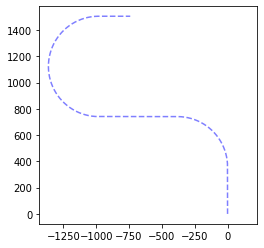

In [3]:
from tma.plot import plot_trajectory
plot_trajectory(observer)

Задаем априорные данные, вектор дистанций, вектор СКО

In [4]:
p0 = [0., 25., 90., 7.]
std_arr = [0., 0.1, 0.2, 0.3, 0.5, 1.]
def target_func(seed=None):
            rng = np.random.RandomState(seed)
            b = 0
            d = rng.uniform(40, 50)
            c = rng.uniform(0, 180)
            v = rng.uniform(3, 15)
            return [b, d, c, v]
result_df = pd.DataFrame(columns=['Algorithm', 'std', 'sr_0', 'sr_1', 'sr_2', 'sr_3', 'Ка', 'Nf', 'Nf_max', 'Iter', 'Iter_max', 't', 't_max'])
mean_columns = ['Ка', 'Nf', 'Iter', 't']
max_columns = ['Nf', 'Iter', 't']

In [5]:
%%time
model = Model(observer)
for std in std_arr:
    model.noise_std = np.radians(std)
    dict_results = swarm(model, algorithm_name='ММП', n=1000, target_func=target_func, p0=p0, seeded=True)
    df = get_df(dict_results)
    df.to_excel('../tests/test7/' + str('ММП') + ' ' + str(std) + '.xlsx', index=False)
    res = pd.DataFrame({'Algorithm': ['ММП'], 'std': [std]})
    for i in range(4):
        res['sr_' + str(i)] = [df['Успех'].apply(lambda x: x[i]).mean(axis=0)]
    res[mean_columns] = df[mean_columns].mean(axis=0)
    res[['Nf_max', 'Iter_max', 't_max']] = df[max_columns].apply(max, axis=0)
    result_df = result_df.append(res)

Wall time: 1min 59s


In [6]:
result_df['Ка'] = result_df['Ка'].apply(np.sqrt)
result_df.rename(columns={'Ка': 'sr_Ka'}, inplace=True)
result_df.reset_index(drop=True)
Path("../tests/test7").mkdir(parents=True, exist_ok=True)
result_df.to_excel('../tests/test7/results4.xlsx', index=False)

In [7]:
display_df = result_df.copy()
precisions = {'sr_Ka' : '{0:.2f}', 'Nf' : '{0:.0f}', 'Nf_max': '{0:.0f}',\
'Iter' : '{0:.0f}', 'Iter_max' : '{0:.0f}', 't' : '{0:.4f}', 't_max' : '{0:.4f}'}
for col, precision in precisions.items():
    display_df[col] = display_df[col].apply(lambda x: precision.format(x))
display_df

,Algorithm,std,sr_0,sr_1,sr_2,sr_3,sr_Ka,Nf,Nf_max,Iter,Iter_max,t,t_max
0,ММП,0.0,1.000,1.000,1.000,1.000,0.00,10,14,9,13,0.0029,0.0286
0,ММП,0.1,0.841,0.946,0.946,0.975,0.10,10,14,9,13,0.0030,0.0227
0,ММП,0.2,0.611,0.841,0.841,0.910,0.20,10,14,9,13,0.0029,0.0131
0,ММП,0.3,0.417,0.725,0.738,0.831,0.30,10,14,9,13,0.0029,0.0383
0,ММП,0.5,0.238,0.521,0.556,0.676,0.50,10,14,9,13,0.0031,0.0245
0,ММП,1.0,0.071,0.241,0.267,0.361,1.00,10,16,9,15,0.0029,0.0180


Сохраняем сводную таблицу в dcox

In [8]:
import docx
doc = docx.Document()
t = doc.add_table(display_df.shape[0]+1, display_df.shape[1])
for j in range(display_df.shape[-1]):
    t.cell(0,j).text = display_df.columns[j]
for i in range(display_df.shape[0]):
    for j in range(display_df.shape[-1]):
        t.cell(i+1,j).text = str(display_df.values[i,j])
doc.save('../tests/test7/Сводная таблица 40-50.docx')